In [ ]:
# pip show torch torchvision


In [ ]:
# pip install torch torchvision --index-url https://download.pytorch.org/whl/cu117


In [ ]:
# !pip uninstall torch torchvision
# !pip install torch torchvision --index-url https://download.pytorch.org/whl/cpu


In [ ]:
# !pip install onnxscript
# !pip install --upgrade torch torchvision
# !pip install torch==2.3.0 torchvision==0.15.1
# !pip uninstall torch torchvision

import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)



2.0.1+cu117
0.15.2+cu117


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt

In [ ]:
# pip install torch
# !pip install torchvision


In [ ]:
import torch
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.get_device_name(0))  # Should print the name of your GPU

print(torch.__version__)


True
NVIDIA GeForce RTX 2060 SUPER
2.0.1+cu117


In [ ]:

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

'''
    Each image in CIFAR-10 is a 32x32 color image with 3 channels (RGB).
    ToTensor: converts image data into Pytorch tensors(numerical format)
    Normalize: scales pixel values to range [-1,1]( from original 0,1) bcoz GANs perform better with normalized ips
'''
# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

'''
    Download & load the cifar10 dataset for taining, organizing it into batches of 64
    Applies transformation defined above.
'''
train_data = datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)


cuda


In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False),
            nn.Tanh()  # Output is scaled between [-1, 1]
        )

    def forward(self, z):
        return self.gen(z)


In [ ]:
'''
this class outputs a single value: a probability of the input being real (1) or fake (0).
'''
class Discriminator(nn.Module):
    def __init__(self):
        #this line initializes the base class(nn.Module) to set up model.
        super(Discriminator, self).__init__()
        #ip will pass through following sequential order of layers
        self.disc = nn.Sequential(
            """
              ulike gen which uses transposed convolutions here we use regular-
              covolutions nn.conv2d to downsample the input image.
              this extracts features & reduces image size properly.

              ip size of imge: 3,32,32 ( 3 channels for RGB)
              output: a feature map of 128

              params:
              3: num of ip channels
              128: num of op channels(features)
              4 : kerenel size
              2 : stride(reduces by 2x)
              1: padding(prevents too much shrinking)

              LeakyRelu introduces a slight slope for neg val instead of completely-
              zeroing them like Relu
              why? it prevents neurons from dieing and stop learning
            """
            nn.Conv2d(3, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            '''
            second block:
            ip: a feature map of 128
            output: a feature map of 256

            BatchNorm2d: normalizes the output of convolution to improve training stability
            leakyRelu: introduces non-linearity
            '''
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            '''
            third block:
            ip: a feature map of 256
            output: a feature map of 512
            '''
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            '''
            fourth block:
            ip: a feature map of 512
            output: a feature map of 1 op channel ( we need single val to classify real/fake)
            nn.sigmoid: outputs into probability range(0,1)
            '''

            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()  # Outputs a probability of real/fake
        )

    '''
    ip image shape: (batch_size,3,32,32)
    self.disc(x) passes the ip through all layer in sequntial order and returns output
    '''
    def forward(self, x):
        return self.disc(x)


In [ ]:
z_dim = 100  # Latent vector dimension (input noise)
'''
  creating gen obj which takes noise ip & generates images
  creating disc obj which takes real/fake ip & outputs prob of being real
  .devide is to move the model to GPU if available
'''
generator = Generator(z_dim).to(device)
discriminator = Discriminator().to(device)


'''
  optimizers:
    Adam optimizer= adjust lr for each parameter dynamically to improve training stability & speed
    gen.parameters() & disc.parameters() retrive learnable weighst so the opt knows which params to update

  betas: control how the opt handles past gradients
'''
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))


'''
  Measures the difference between predicted probabilities and actual labels.
  Used because the discriminator outputs a probability (real = 1, fake = 0).
  Generator: Wants to "trick" the discriminator into predicting 1 (real) for fake images.
  Discriminator: Wants to output 1 for real images and 0 for fake ones.
'''
# Loss function
criterion = nn.BCELoss()


In [ ]:
# Initialize lists to store losses
generator_losses = []
discriminator_losses = []


In [ ]:
num_epochs = 1000 # Adjust as needed
images_per_epoch = 5  # Number of PNGs to save per epoch
gen_updates_per_disc = 1
batches_to_save = images_per_epoch
for epoch in range(num_epochs):
  '''
    This loop iterates over batches of data from the CIFAR-10 training dataset
    real_images: actual cifar10 images
    batch_size: 64
  '''
    for i, (real_images, _) in enumerate(train_loader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Train Discriminator
        '''
          clear any previously calc gradients.
        '''
        optimizer_d.zero_grad()

        # Real images
        real_labels = torch.ones(batch_size, 1).to(device)  #Tensor of all 1s (since real images are labeled as "real").
        output_real = discriminator(real_images)
         # Reshape output_real to match real_labels shape
        output_real = output_real.view(-1, 1)             # Flatten the output. The discriminator's prediction for real images.
        loss_real = criterion(output_real, real_labels)    #Measures how well the discriminator predicts real images as real.


        # Fake images
        z = torch.randn(batch_size, z_dim, 1, 1).to(device)
        fake_images = generator(z) #Fake images generated by the generator.
        fake_labels = torch.zeros(batch_size, 1).to(device) #Tensor of all 0s (since fake images are labeled as "fake").
        output_fake = discriminator(fake_images.detach())
        # Reshape output_fake to match fake_labels shape
        output_fake = output_fake.view(-1, 1) # Flatten the output
        loss_fake = criterion(output_fake, fake_labels) #Measures how well the discriminator predicts fake images as fake


        loss_d = loss_real + loss_fake #Total discriminator loss, combining real and fake image losses.
        loss_d.backward() #Calculates gradients.
        optimizer_d.step() #updates disc weights.


        # Train Generator multiple times
        for _ in range(gen_updates_per_disc):
            optimizer_g.zero_grad()

            # Generate fake images and fool the discriminator
            z = torch.randn(batch_size, z_dim, 1, 1).to(device) #random noise ip for gen
            fake_images = generator(z) #fake images created by gen
            output_fake_g = discriminator(fake_images)
            # Reshape output_fake_g to match real_labels shape
            output_fake_g = output_fake_g.view(-1, 1)  #The discriminator's prediction for fake ima
            loss_g = criterion(output_fake_g, real_labels) #Measures how well the generator fools the discriminator.

            loss_g.backward()
            optimizer_g.step()


        # # Train Generator
        # optimizer_g.zero_grad()

        #  # Generate fake images and fool the discriminator
        # output_fake_g = discriminator(fake_images)
        # # Reshape output_fake_g to match real_labels shape
        # output_fake_g = output_fake_g.view(-1, 1) # Flatten the output
        # loss_g = criterion(output_fake_g, real_labels)


        # loss_g.backward()
        # optimizer_g.step()

        # Append losses
        generator_losses.append(loss_g.item())
        discriminator_losses.append(loss_d.item())


        # Print losses every 200 steps to monitor training progress
        if (i+1) % 200 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], "
                  f"Discriminator Loss: {loss_d.item():.4f}, Generator Loss: {loss_g.item():.4f}")
        # print(f'i:{i} & batches_to_save:{batches_to_save}\n')
        # Save generated images for visualization
        if i<batches_to_save:
            #saving a batch of gen images.
            # print(f'saving images {batches_to_save}')
            with torch.no_grad():
                z = torch.randn(64, z_dim, 1, 1).to(device)
                fake_images = generator(z).detach().cpu()
                save_image(fake_images, f'generated_images_epoch_{epoch+1}_batch_{i+1}.png', normalize=True)
                #normalize= True makes images more viewable.

Epoch [1/1000], Step [200/782], Discriminator Loss: 0.0772, Generator Loss: 7.4309
Epoch [1/1000], Step [400/782], Discriminator Loss: 0.5017, Generator Loss: 2.9408
Epoch [1/1000], Step [600/782], Discriminator Loss: 0.3410, Generator Loss: 4.6519
Epoch [2/1000], Step [200/782], Discriminator Loss: 0.4899, Generator Loss: 2.4848
Epoch [2/1000], Step [400/782], Discriminator Loss: 0.6507, Generator Loss: 4.2780
Epoch [2/1000], Step [600/782], Discriminator Loss: 0.2098, Generator Loss: 2.6503
Epoch [3/1000], Step [200/782], Discriminator Loss: 0.6635, Generator Loss: 5.7107
Epoch [3/1000], Step [400/782], Discriminator Loss: 0.2001, Generator Loss: 3.2123
Epoch [3/1000], Step [600/782], Discriminator Loss: 0.4317, Generator Loss: 3.2737
Epoch [4/1000], Step [200/782], Discriminator Loss: 0.6204, Generator Loss: 2.8122
Epoch [4/1000], Step [400/782], Discriminator Loss: 0.5643, Generator Loss: 2.5752
Epoch [4/1000], Step [600/782], Discriminator Loss: 0.4736, Generator Loss: 2.3715
Epoc

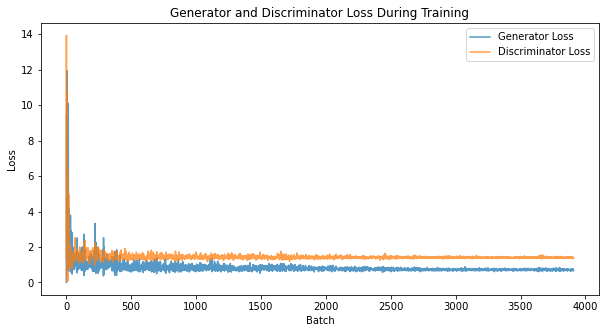

In [ ]:


# Plot generator and discriminator losses
plt.figure(figsize=(10, 5))
plt.plot(generator_losses, label="Generator Loss", alpha=0.75)
plt.plot(discriminator_losses, label="Discriminator Loss", alpha=0.75)
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Generator and Discriminator Loss During Training")
plt.legend()
plt.show()
